In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
#
#from keras.optimizers import Adam
#from generator import DataGenerator
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality
import cv2
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight
import seaborn as sn

In [2]:
train_dir = os.path.abspath(r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/train.csv")
traindf=pd.read_csv(train_dir, dtype=str)

valid_dir = os.path.abspath(r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/valid.csv")
validdf=pd.read_csv(valid_dir, dtype=str)

for i in range(len(traindf)):
    traindf.iloc[i,0] = r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/" + traindf.iloc[i,0]

for i in range(len(validdf)):
    validdf.iloc[i,0] = r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/" + validdf.iloc[i,0]

In [3]:
"""paths = []
for i in range(len(aptraindf[aptraindf["Pneumonia"] == "1.0"]["Path"])):
    paths.append(aptraindf[aptraindf["Pneumonia"] == "1.0"]["Path"].iloc[i])"""

'paths = []\nfor i in range(len(aptraindf[aptraindf["Pneumonia"] == "1.0"]["Path"])):\n    paths.append(aptraindf[aptraindf["Pneumonia"] == "1.0"]["Path"].iloc[i])'

In [4]:
"""X_train = np.array(get_imgs(paths))
train_images = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]"""

"X_train = np.array(get_imgs(paths))\ntrain_images = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1).astype('float32')\ntrain_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]"

In [5]:
"""IMG_SIZE = 256
def get_imgs(paths):
    images = []
    for i in paths:
        #images.append(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE))) 
        images.append(cv2.cvtColor(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)), cv2.COLOR_BGR2GRAY))
    return images """

'IMG_SIZE = 256\ndef get_imgs(paths):\n    images = []\n    for i in paths:\n        #images.append(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE))) \n        images.append(cv2.cvtColor(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)), cv2.COLOR_BGR2GRAY))\n    return images '

In [6]:
aptrainlist = []
for i in range(int(0.95*(len(traindf)))):
    if (traindf.iloc[i,4] == "AP"):
        aptrainlist.append(traindf.iloc[i,:])

aptraindf = pd.DataFrame(aptrainlist)

In [7]:
apvalidlist = []
for i in range(int(0.95*(len(traindf))),len(traindf)):
    if (traindf.iloc[i,4] == "AP"):
        apvalidlist.append(traindf.iloc[i,:])

apvaliddf = pd.DataFrame(apvalidlist)

In [8]:
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

IMG_SIZE = (256, 256) # slightly smaller than vgg16 normally expects
datagen = ImageDataGenerator()

In [9]:
aptraindf["Pneumonia"] = aptraindf["Pneumonia"].replace(np.nan, 0)
aptraindf["Pneumonia"] = aptraindf["Pneumonia"].replace("-1.0", 0)
aptraindf["Pneumonia"] = aptraindf["Pneumonia"].replace("0.0", 0)
aptraindf["Pneumonia"] = aptraindf["Pneumonia"].replace("1.0", 1)
aptraindf["Pneumonia"] = aptraindf["Pneumonia"].apply(str)

In [10]:
apvaliddf["Pneumonia"] = apvaliddf["Pneumonia"].replace(np.nan, 0)
apvaliddf["Pneumonia"] = apvaliddf["Pneumonia"].replace("-1.0", 0)
apvaliddf["Pneumonia"] = apvaliddf["Pneumonia"].replace("0.0", 0)
apvaliddf["Pneumonia"] = apvaliddf["Pneumonia"].replace("1.0", 1)
apvaliddf["Pneumonia"] = apvaliddf["Pneumonia"].apply(str)

In [11]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=apvaliddf,
    x_col="Path",
    y_col="Pneumonia",
    #subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(256,256))

Found 10619 validated image filenames belonging to 2 classes.


In [12]:
test_X, test_Y = next(datagen.flow_from_dataframe(
    dataframe=apvaliddf,
    x_col="Path",
    y_col="Pneumonia",
    batch_size = 8000,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(256,256)))

Found 10619 validated image filenames belonging to 2 classes.


In [13]:
train_generator=datagen.flow_from_dataframe(
    dataframe=aptraindf,
    x_col="Path",
    y_col="Pneumonia",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(256,256))

Found 150971 validated image filenames belonging to 2 classes.


In [14]:
t_x, t_y = next(train_generator)

In [15]:
from collections import Counter
training_data_classes = Counter(train_generator.classes)
num_no_findings_class = training_data_classes[1] 
num_findings_class = training_data_classes[0]

print(training_data_classes)

class_weights = [num_findings_class/num_no_findings_class,0.5]

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

Counter({0: 147742, 1: 3229})


In [16]:
# dense net model
img_in = Input(t_x.shape[1:])              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 

x = model.output  
predictions = Dense(1, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

29097984/29084464 [==============================] - 1s 0us/step


In [17]:
#########################################
import tensorflow as tf
#loaded_model = tf.keras.models.load_model('../input/nih-cxr-weight0102414/weights.best.01-0.24.hdf5')

In [18]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

#model.load_weights('../input/chestxray8-dataframe/pretrained_model.h5')

In [19]:
# set up a checkpoint for model training
# https://keras.io/callbacks/
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
callbacks_list = [checkpointer]

In [20]:
history = model.fit(train_generator, 
                                  steps_per_epoch=100,
                                  validation_steps=1,
                                  validation_data=valid_generator, 
                                  epochs = 25 , callbacks = callbacks_list, class_weight=class_weights_dict)

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.6208 - binary_accuracy: 0.9759
Epoch 00001: val_loss improved from inf to 0.00193, saving model to weights.best.01-0.00.hdf5
100/100 [==============================] - 26s 152ms/step - loss: 0.6208 - binary_accuracy: 0.9759 - val_loss: 0.0019 - val_binary_accuracy: 1.0000
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.1088 - binary_accuracy: 0.9766
Epoch 00002: val_loss did not improve from 0.00193
100/100 [==============================] - 14s 139ms/step - loss: 0.1088 - binary_accuracy: 0.9766 - val_loss: 0.2515 - val_binary_accuracy: 0.9688
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.1014 - binary_accuracy: 0.9787
Epoch 00003: val_loss did not improve from 0.00193
100/100 [==============================] - 15s 148ms/step - loss: 0.1014 - binary_accuracy: 0.9787 - val_loss: 0.2254 - val_binary_accuracy: 0.9688
Epoch 4/25
100/100 [==============================]

250/250 [==============================] - 10s 35ms/step


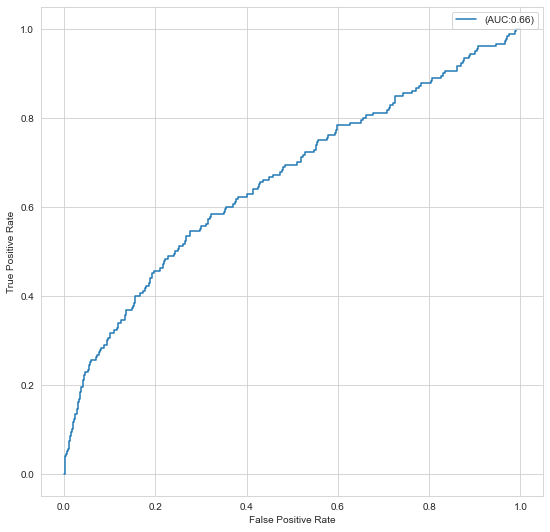

In [21]:
pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = roc_curve(test_Y[:].astype(int), pred_Y[:])
c_ax.plot(fpr, tpr, label = '(AUC:%0.2f)'  % (auc(fpr, tpr)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

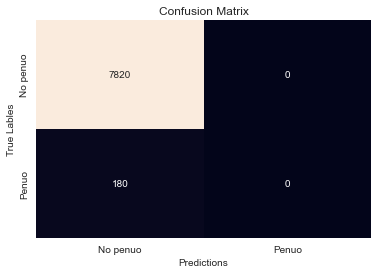

In [22]:
pred_Y_binary = []

for i in range(len(pred_Y)):
    if pred_Y[i] <= 0.5:
        pred_Y_binary.append(0)
    else:
        pred_Y_binary.append(1)
        
all_labels = ["No penuo", "Penuo"]

confusion_array = confusion_matrix(test_Y, pred_Y_binary)

df_cm = pd.DataFrame(confusion_array, 
                    index = [i for i in all_labels],
                  columns = [i for i in all_labels ])

ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", ax = ax, cbar=False)

ax.set_title('Confusion Matrix')
ax.set_xlabel("Predictions")
ax.set_ylabel("True Lables")

plt.show()